In [1]:
%config IPCompleter.use_jedi=False
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Problem 1
## 1.

In [2]:
def gen_Markov_1_seq(num_samples, rho=0.6):
    x = []
    prev_x = np.random.randn()
    
    for i in range(num_samples):
        prev_x = rho*prev_x + np.random.randn()
        x.append(prev_x)
    return x

In [3]:
def gen_X(num_realizations=10000, rho=0.6, base=1000):
    x = gen_Markov_1_seq((base+num_realizations)*2)
    X = []
    for i in range(base, base+num_realizations):
        X.append(np.array([x[2*i],x[2*i+1]]))
    X = np.array(X)
    return X

In [4]:
num_realizations = 10000
rho = 0.6

X = gen_X(num_realizations, rho)

### a

In [5]:
tilde_C_xx = np.zeros((2,2))
for i in range(num_realizations):
    tilde_C_xx += np.outer(X[i],X[i])
tilde_C_xx /= num_realizations

tilde_C_xx

array([[1.54793647, 0.92991821],
       [0.92991821, 1.56465269]])

### b

In [6]:
_, tilde_U = np.linalg.eig(tilde_C_xx)
tilde_U

array([[-0.71027728, -0.703922  ],
       [ 0.703922  , -0.71027728]])

### c

In [7]:
var_X_n = 1/(1-rho**2)
C_xx = np.array([[var_X_n, var_X_n*rho],[var_X_n*rho, (var_X_n*rho**2)+1]])
C_xx

array([[1.5625, 0.9375],
       [0.9375, 1.5625]])

In [8]:
_, U = np.linalg.eig(C_xx)
U

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

### d

## 2.

### a

In [9]:
T = U.T
C_yy = T@C_xx@T.T
C_yy

array([[2.50000000e+00, 0.00000000e+00],
       [1.66533454e-16, 6.25000000e-01]])

### b

In [20]:
len_coef = 2
optim_R = {}

# Compute overall distortion
total_dist = 1
for c in range(len_coef):
     total_dist *= C_yy[c,c]
total_dist**=(1/len_coef)

# Compute alloacted bits w.r.t variances
alloc_bits = np.ones((len_coef,))
for c in range(len_coef):
    alloc_bits[c] = 0.5*np.log2(C_yy[c,c]/total_dist)

for r in range(1,6):
    R = r/len_coef
    optim_R[r] = np.ones((len_coef,))*R + alloc_bits
    

optim_R[2] = np.array([2, 0])
optim_R[4] = np.array([3, 1])
optim_R

{1: array([1., 0.]),
 2: array([2, 0]),
 3: array([2., 1.]),
 4: array([3, 1]),
 5: array([3., 2.])}

### c

In [11]:
col = np.array(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99',
                '#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a', '#9321ec'])
_magic = np.random.randint(len(col)-1)

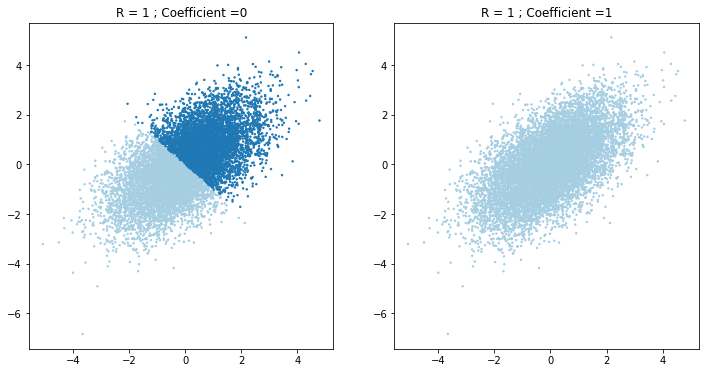

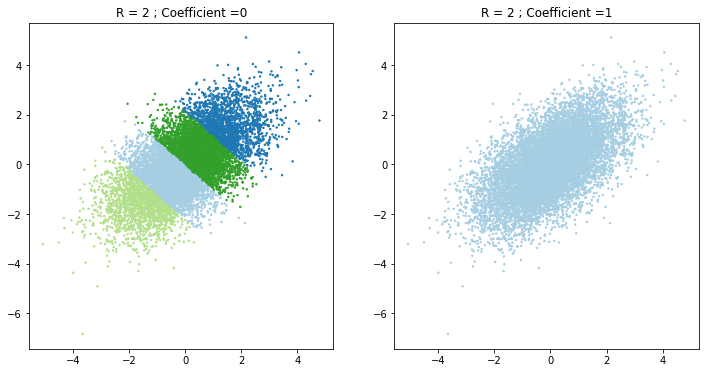

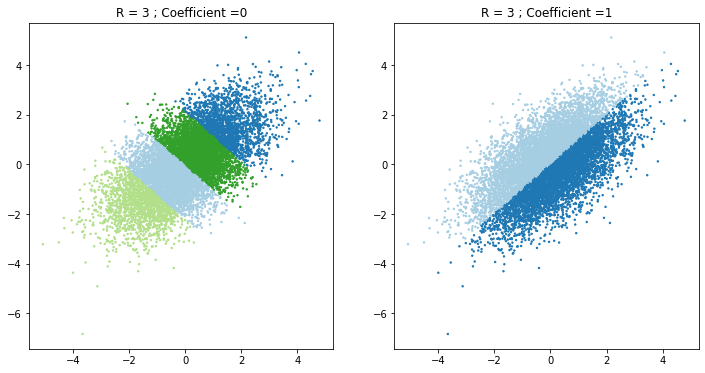

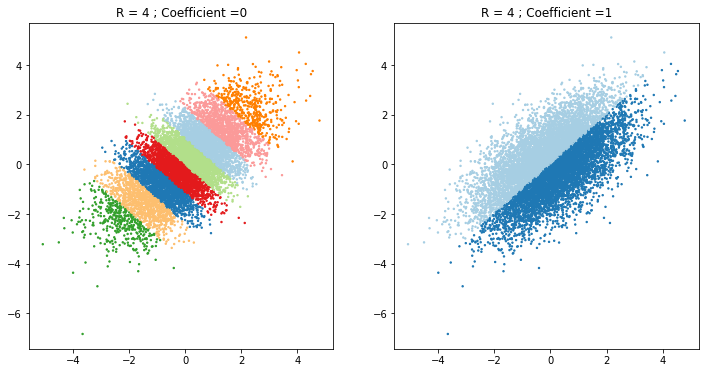

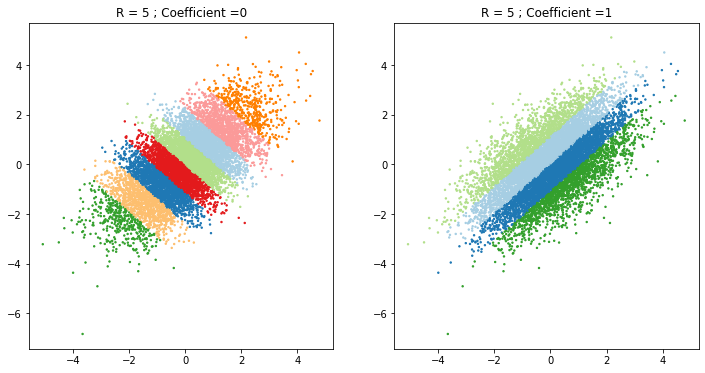

In [12]:
# Get Y
Y = []
for _X in X:
    Y.append(T@_X)
Y = np.array(Y).T

kmeans_model = {}
for avg_R, alloc_Rs in optim_R.items():
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    kmeans_model[avg_R] = {}
    
    for idx, alloc_R in enumerate(alloc_Rs):
        num_bins = 2**int(alloc_R)
        
        kmeans = KMeans(n_clusters=num_bins, random_state=0).fit(Y[idx].reshape(-1,1))
        kmeans_model[avg_R][idx] = kmeans
        labels = kmeans.labels_
        axs[idx].scatter(X[:,0], X[:,1], c=col[(labels*_magic)%len(col)], s=2)
        axs[idx].set_title('R = '+str(avg_R)+' ; Coefficient ='+str(idx))
        
        
    fig.show()

### d

In [13]:
distortions = []

for avg_R, alloc_Rs in optim_R.items():
    quantized_Y = []
    
    for idx, alloc_R in enumerate(alloc_Rs):
        num_bins = 2**int(alloc_R)
        quantized_Y.append([kmeans_model[avg_R][idx].cluster_centers_[i][0] for i in kmeans_model[avg_R][idx].labels_])
        
    quantized_Y = np.array(quantized_Y)

    quantized_X = (U@quantized_Y).T
    distortions.append(np.mean((X - quantized_X)**2))

In [14]:
distortions

[0.7652282006963055,
 0.4589215222695376,
 0.25747383467744905,
 0.15518784114788411,
 0.07971246047968228]

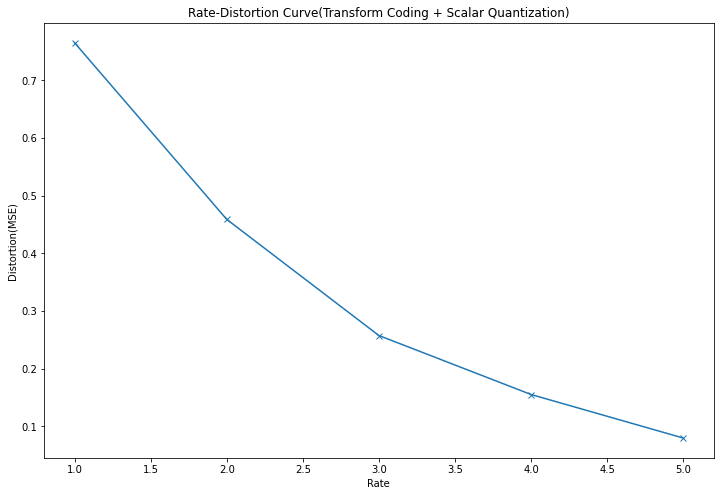

In [15]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(1,6), distortions, marker='x')
plt.xlabel('Rate')
plt.ylabel('Distortion(MSE)')
plt.title('Rate-Distortion Curve(Transform Coding + Scalar Quantization)')
plt.show()

## 3

### a

In [16]:
X

array([[ 0.3685239 ,  0.45040197],
       [-0.72374833, -0.29160868],
       [ 1.11877677,  0.68016336],
       ...,
       [-0.40166268, -0.56829928],
       [-2.36137709, -0.7806447 ],
       [ 0.61286766,  1.24271933]])

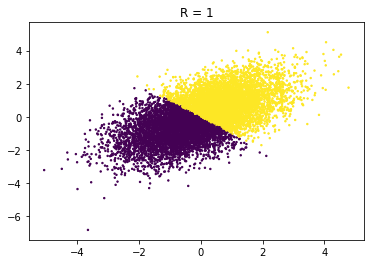

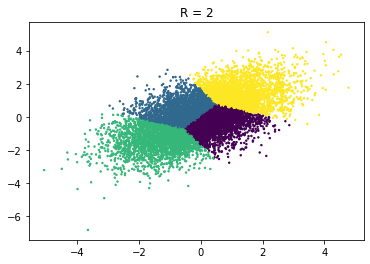

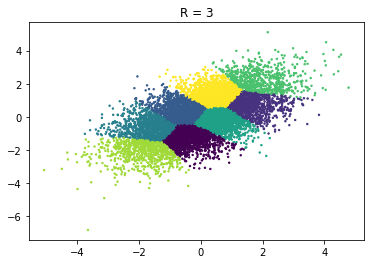

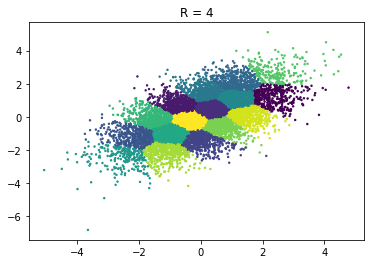

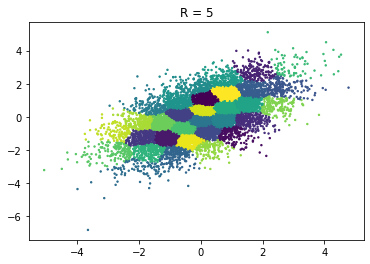

In [17]:
distortions = []

for R in range(1,6):
    num_bins = 2**R
    
    kmeans = KMeans(n_clusters=num_bins).fit(X)

    quantized_X = []
    for idx in range(len(X)):
        quantized_X.append(kmeans.cluster_centers_[kmeans.labels_[idx]])
    
    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, s=2)
    plt.title('R = '+str(R))
    plt.show()
        
    distortions.append(np.mean((X-quantized_X)**2))

In [18]:
distortions

[0.7652315393566903,
 0.4412808704000801,
 0.24062075969922567,
 0.13101517555992714,
 0.06927897437650612]

### b

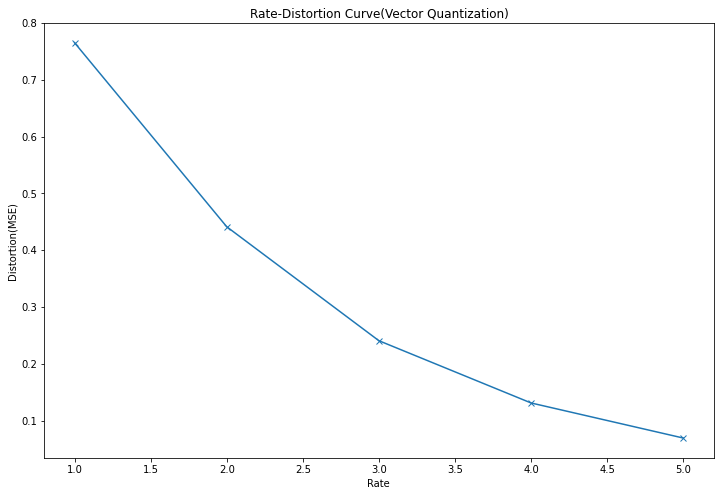

In [19]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(1,6), distortions, marker='x')
plt.xlabel('Rate')
plt.ylabel('Distortion(MSE)')
plt.title('Rate-Distortion Curve(Vector Quantization)')
plt.show()